<a href="https://colab.research.google.com/github/SHUBHR1005/PROJECTS/blob/main/DISASTER_TWEETS_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font face="Arial" size="6" color="MediumSeaGreen"><b> $\bullet$ ANALYZING DISASTER TWEETS: NLP, EDA, AND BERT WITH TRANSFORMERS IN PYTORCH</b></font>

---


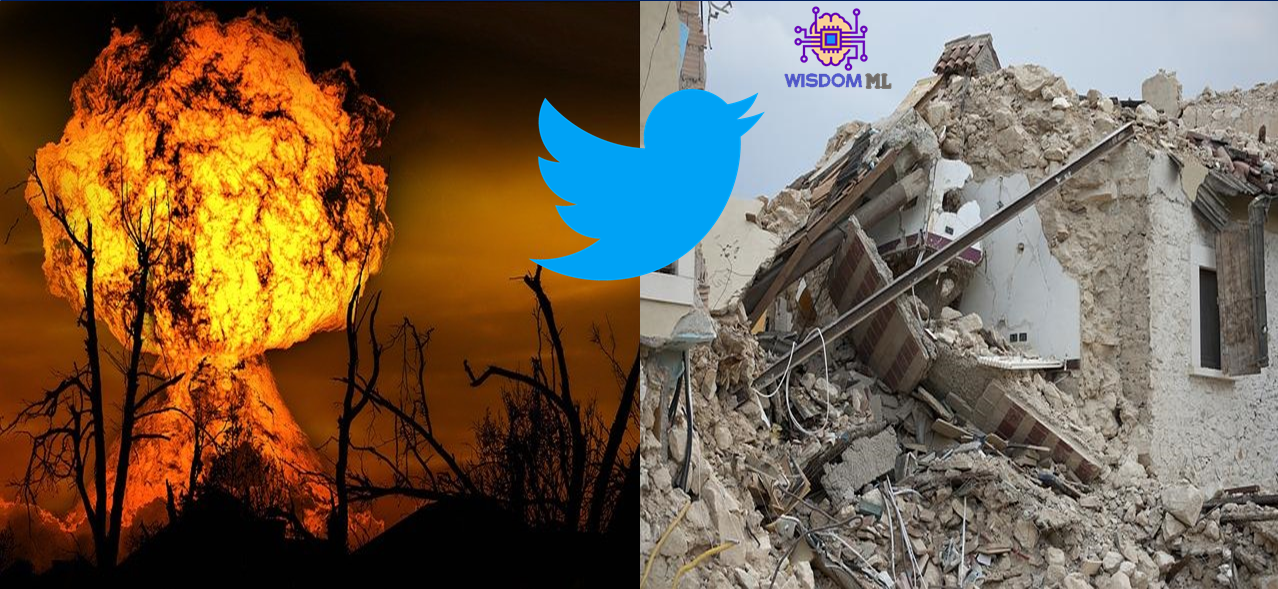

## <font face="Monospace" size="7" color="MediumSeaGreen"><b>INTRODUCTION</b></font>

---

Classifying disaster-related tweets is crucial for efficient crisis management. Given the prevalence of Twitter as a news source, distinguishing genuine disaster information from noise is challenging. Utilizing NLP techniques like BERT, this task involves training models to automatically differentiate between authentic disaster-related tweets and non-relevant content, aiding in real-time information dissemination and emergency response.

## <font face="Monospace" size="7" color="MediumSeaGreen"><b>PREDICTION OBJECTIVE</b></font>

I am making predictions regarding whether a provided tweet pertains to an actual disaster. In case it does, my prediction will be 1; if not, it will be 0.

## <font face="Monospace" size="7" color="MediumSeaGreen"><b>IMPORTING LIBRARIES</b></font>

---

We will begin by importing a variety of libraries that will be utilized throughout our notebook. To enhance readability, I have organized them into distinct groups based on their intended purposes, indicated by the use of '#' symbols. This should make the code more comprehensible and structured.

In [ ]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import  train_test_split

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


# Loading tensorflow, keras

from keras.utils import pad_sequences

# Setting some options for general use.

from tqdm import tqdm, trange
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011718 sha256=e061efe82054b56f477a7495ad5b7741cab5af18b4be46ba0bd105cf4a05630f
  Stored in directory: /root/.cache/pip/wheels/28/45/a9/c35b2107f053046bd5ac0b1adb5ea970938b02b134e49b9a06
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.6.0
    Uninstalling en-core-web-sm-3.6.0:
      Successfully uninstalled en-core-web-sm-3.6.0


/usr/local/lib/python3.10/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.6.1,<3.7.0
  warnings.warn(warn_msg)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00


## <font face="Monospace" size="7" color="MediumSeaGreen"><b>DATA PREPERATION</b></font>

---

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>DATA</b></font>

---

We will proceed to load both our training and testing data. In the variable names, I've included "v" at the end to indicate their potential usage in visualization and exploratory data analysis (EDA), as some preprocessing steps might not be essential for modeling. Let's now examine the provided dataset:

The dataset comprises keywords, locations, text content, and corresponding target labels. For our modeling purposes, we will focus on utilizing the text feature.






In [ ]:
trainv = pd.read_csv('/content/drive/MyDrive/DATASET/DISTWEET_TRAIN.csv')
testv = pd.read_csv('/content/drive/MyDrive/DATASET/DISTWEET TEST.csv')

In [ ]:
display(trainv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
display(testv.sample(5))

,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


### <font face="Monospace" size="6" color="MediumSeaGreen"><b>DATA INFORMATION</b></font>

---

In [ ]:
print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


### <font face="Monospace" size="6" color="MediumSeaGreen"><b>DATA CLEANING</b></font>

---

Before visualizing the text data, we'll enhance it using helper functions to address URLs, emojis, HTML tags, and punctuations. The cleaned text will be stored in a new column labeled 'text_clean'. Then, we'll tokenize the words, convert them to lowercase, and remove stopwords using NLTK's library. For lemmatization, we'll incorporate part-of-speech tags, transform them into WordNet format, and apply lemmatization. The resulting lemmatized words will be saved in a 'lemmatized' column. Lastly, the tokenized lists will be converted back to string format for future use.

So basically what we did are:
* Removed urls, emojis, html tags and punctuations,
* Tokenized the tweet base texts,
* Lower cased clean text,
* Removed stopwords,
* Applied part of speech tags,
* Converted part of speeches to wordnet format,
* Applying word lemmatizer,
* Converted tokenized text to string again.

In [ ]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
# Tokenizing the tweet base texts.

trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)


In [ ]:
# Lower casing clean text.

trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])


In [ ]:
# Removing stopwords.

trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])


In [ ]:
# Applying part of speech tags.

trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)


In [ ]:
trainv

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."
...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,"[Two, giant, cranes, holding, a, bridge, colla...","[two, giant, cranes, holding, a, bridge, colla...","[two, giant, cranes, holding, bridge, collapse...","[(two, CD), (giant, JJ), (cranes, NNS), (holdi..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The out of control wild...,"[ariaahrary, TheTawniest, The, out, of, contro...","[ariaahrary, thetawniest, the, out, of, contro...","[ariaahrary, thetawniest, control, wild, fires...","[(ariaahrary, JJ), (thetawniest, JJS), (contro..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M194 0104 UTC5km S of Volcano Hawaii,"[M194, 0104, UTC5km, S, of, Volcano, Hawaii]","[m194, 0104, utc5km, s, of, volcano, hawaii]","[m194, 0104, utc5km, volcano, hawaii]","[(m194, NN), (0104, CD), (utc5km, JJ), (volcan..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an ebike collided w...,"[Police, investigating, after, an, ebike, coll...","[police, investigating, after, an, ebike, coll...","[police, investigating, ebike, collided, car, ...","[(police, NNS), (investigating, VBG), (ebike, ..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])


In [ ]:
trainv

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,"[Two, giant, cranes, holding, a, bridge, colla...","[two, giant, cranes, holding, a, bridge, colla...","[two, giant, cranes, holding, bridge, collapse...","[(two, CD), (giant, JJ), (cranes, NNS), (holdi...","[(two, n), (giant, a), (cranes, n), (holding, ..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The out of control wild...,"[ariaahrary, TheTawniest, The, out, of, contro...","[ariaahrary, thetawniest, the, out, of, contro...","[ariaahrary, thetawniest, control, wild, fires...","[(ariaahrary, JJ), (thetawniest, JJS), (contro...","[(ariaahrary, a), (thetawniest, a), (control, ..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M194 0104 UTC5km S of Volcano Hawaii,"[M194, 0104, UTC5km, S, of, Volcano, Hawaii]","[m194, 0104, utc5km, s, of, volcano, hawaii]","[m194, 0104, utc5km, volcano, hawaii]","[(m194, NN), (0104, CD), (utc5km, JJ), (volcan...","[(m194, n), (0104, n), (utc5km, a), (volcano, ..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an ebike collided w...,"[Police, investigating, after, an, ebike, coll...","[police, investigating, after, an, ebike, coll...","[police, investigating, ebike, collided, car, ...","[(police, NNS), (investigating, VBG), (ebike, ...","[(police, n), (investigating, v), (ebike, n), ..."


In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


## <font face="Monospace" size="7" color="MediumSeaGreen"><b>DATA VISUALIZATION</b></font>

---

Our cleaned and organized text data is now primed for visualization. Through this process, we aim to uncover visible connections and patterns among different tweet classes, providing us with valuable insights into the dataset's dynamics.

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>TARGET DISTRIBUTION</b></font>

---

Upon examining the distribution of our target variables, we observe that they are fairly balanced. The disparities between the classes are not substantial, which is indicative of a favorable scenario for modeling.

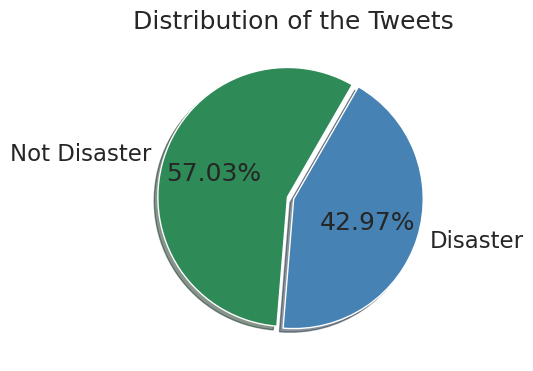

In [ ]:
fig= plt.subplots(figsize=(10, 4), dpi=100)
colors = ['seagreen', 'steelblue']
plt.pie(trainv['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60,
        colors=colors)
plt.title('Distribution of the Tweets', fontsize=18)
plt.show()

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>TWEET LENGTHS</b></font>

---

We'll commence by analyzing the character count per tweet and contrasting its relationship with disaster and non-disaster categorizations. Generally, it appears that tweets related to disasters tend to be lengthier compared to those unrelated to disasters. However, it's important to note that this assumption is based on preliminary observations and may not necessarily hold true in all cases.






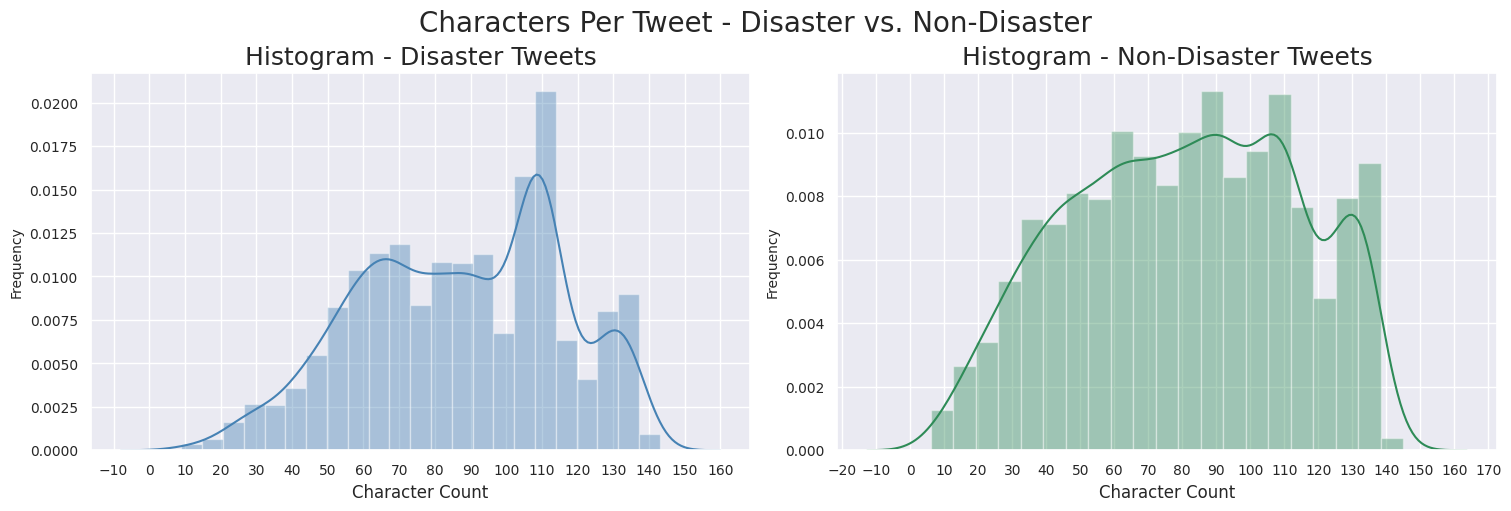

In [ ]:
trainv['Character Count'] = trainv['text_clean'].apply(lambda x: len(str(x)))

def plot_dist3(df, feature, title):
    # Creating a customized chart and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(15, 5))
    # Creating a grid of 1 row and 2 cols.
    grid = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

    # Customizing the histogram grid for disaster tweets.
    ax1 = fig.add_subplot(grid[0, 0])
    # Set the title.
    ax1.set_title('Histogram - Disaster Tweets')
    # Plot the histogram.
    sns.distplot(df[df['target'] == 1][feature],  # Filter disaster tweets
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='steelblue')
    ax1.set(ylabel='Frequency')
    ax1.yaxis.label.set_fontsize(10)
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Adjusting x-axis and y-axis titles for the first subplot.
    ax1.set_xlabel('Character Count', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # Customizing the histogram grid for non-disaster tweets.
    ax2 = fig.add_subplot(grid[0, 1])
    # Set the title.
    ax2.set_title('Histogram - Non-Disaster Tweets')
    # Plot the histogram.
    sns.distplot(df[df['target'] == 0][feature],  # Filter non-disaster tweets
                 hist=True,
                 kde=True,
                 ax=ax2,
                 color='seagreen')
    ax2.set(ylabel='Frequency')
    ax2.yaxis.label.set_fontsize(10)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Adjusting x-axis and y-axis titles for the second subplot.
    ax2.set_xlabel('Character Count', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    plt.suptitle(f'{title}', fontsize=20)

# Call the function with your data
plot_dist3(trainv, 'Character Count', 'Characters Per Tweet - Disaster vs. Non-Disaster')

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>WORD COUNTS</b></font>

---

Let's analyze the word count distribution in each tweet. Both sets of tweets exhibit a somewhat normal distribution. Notably, tweets related to disasters seem to have slightly more words compared to non-disaster tweets. In the upcoming section, we'll delve deeper into this aspect for more insights.

In [ ]:
def plot_word_number_histogram(textno, textye):

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='seagreen')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='steelblue')

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')

    fig.tight_layout()

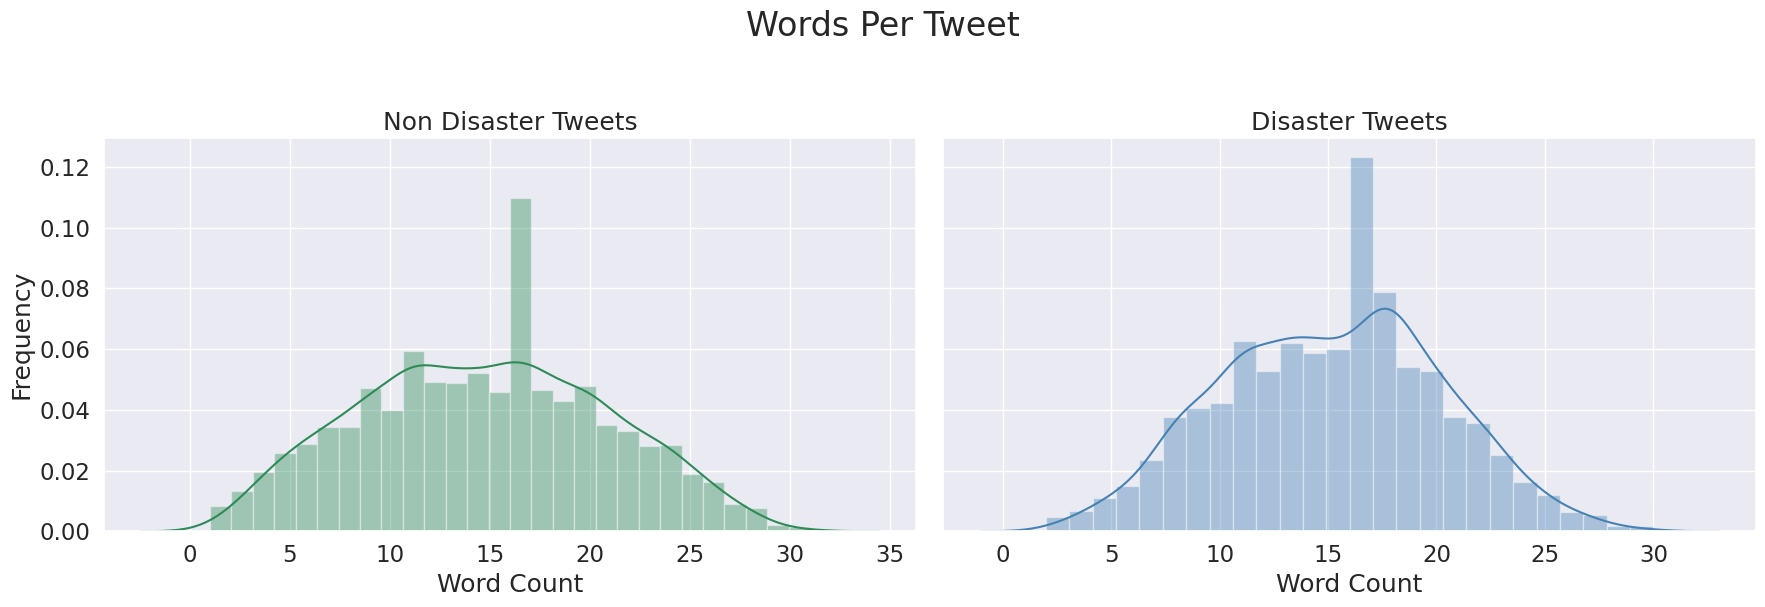

In [ ]:
plot_word_number_histogram(trainv[trainv['target'] == 0]['text'],
                           trainv[trainv['target'] == 1]['text'])

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>WORD LENGTHS</b></font>

---

In the following analysis, we'll explore the potential differences in word complexity between tweet classes. Preliminary observations indicate that disaster-related tweets generally contain longer words compared to non-disaster tweets. This observable trend bodes well, although it's important to acknowledge that these conclusions are still somewhat speculative at this stage.

In [ ]:
def plot_word_len_histogram(textno, textye):

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='seagreen')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='steelblue')

    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

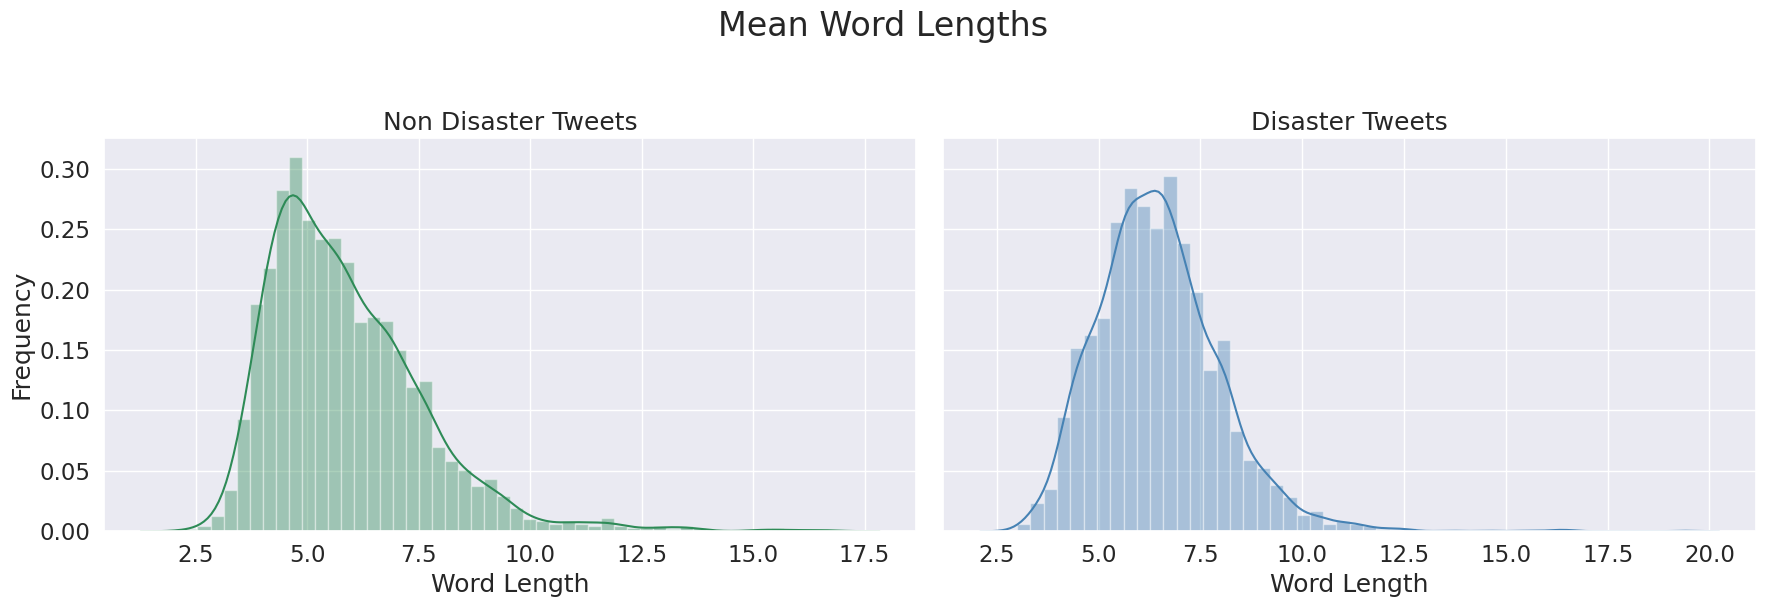

In [ ]:
plot_word_len_histogram(trainv[trainv['target'] == 0]['text'],
                        trainv[trainv['target'] == 1]['text'])

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>MOST COMMON WORDS</b></font>

---

Let's shift our focus from the quantitative attributes of words to the words themselves. We'll initiate this exploration by examining the most frequently used words in both classes. The distinction between disaster-related tweets and non-disaster tweets seems quite apparent. Disaster tweets commonly feature words such as "fire," "kill," and "bomb," strongly suggesting their association with calamities. In contrast, non-disaster tweets exhibit more generic terms.

This shift allows us to gain insights into the distinctive language patterns between the two classes.

In [ ]:
lis = [
    trainv[trainv['target'] == 0]['lemma_str'],
    trainv[trainv['target'] == 1]['lemma_str']
]

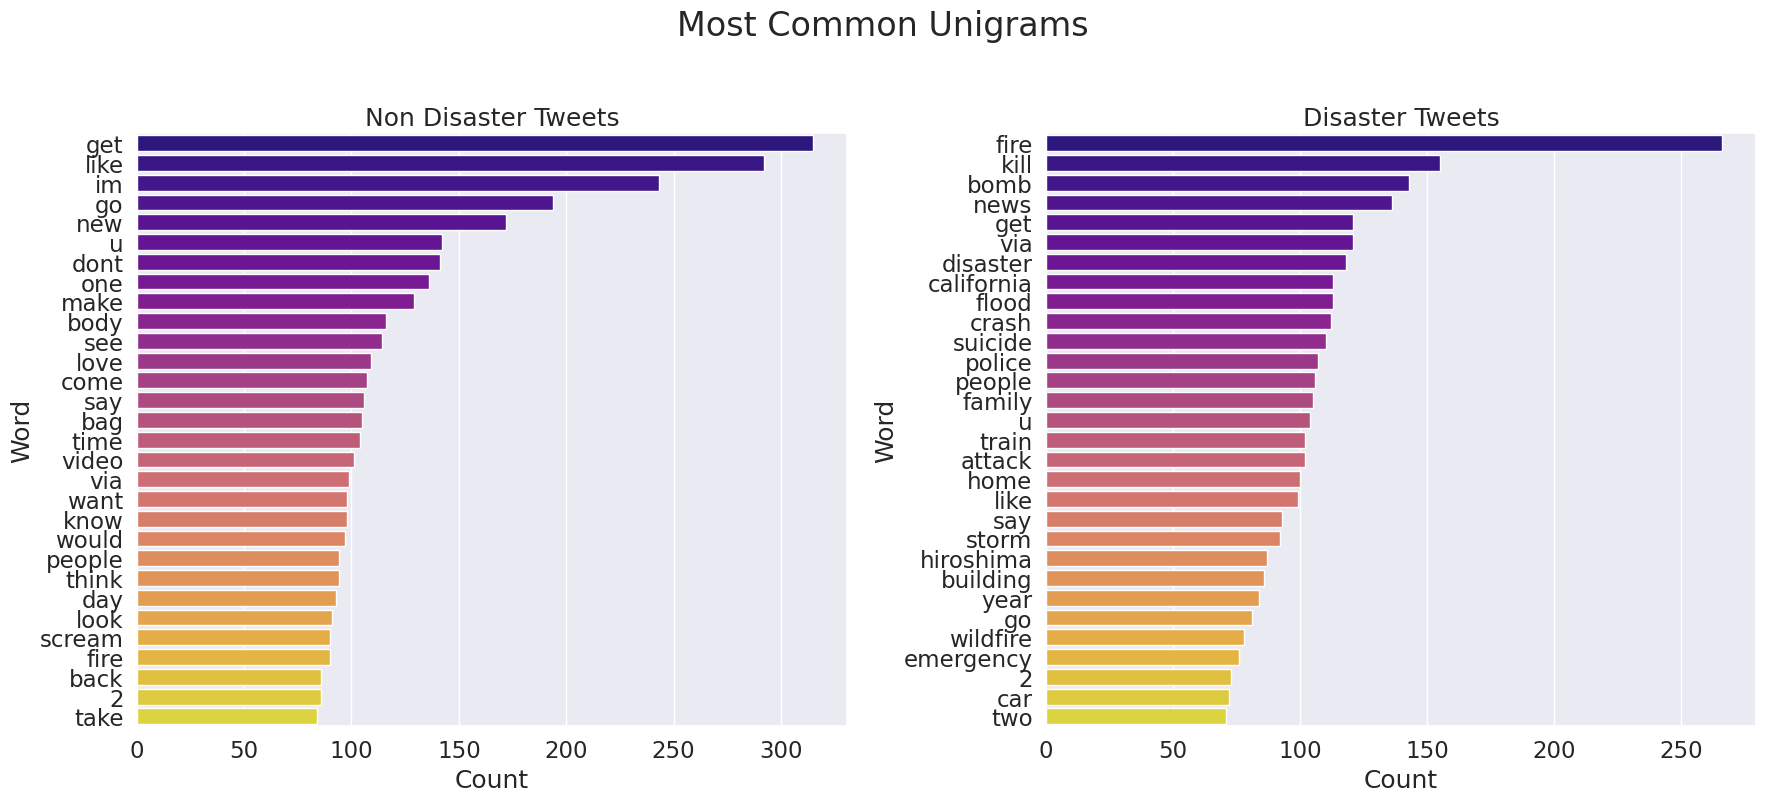

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>MOST COMMON N-GRAMS</b></font>

---

We are transitioning to an analysis centered around the actual words rather than their quantitative attributes. We will begin by investigating n-grams, specifically the most common words or phrases, in both classes. The distinction between disaster and non-disaster tweets becomes evident. Disaster-related tweets prominently feature terms like "fire," "kill," and "bomb," strongly associating them with calamities. In contrast, non-disaster tweets tend to utilize more general language.

In [ ]:
def ngrams(n, title):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count',fontsize=14)
        axes[0].set_ylabel('Words',fontsize=14)
        axes[1].set_xlabel('Count',fontsize=14)
        axes[1].set_ylabel('Words',fontsize=14)
        axes[0].tick_params(axis='y', labelsize=8)
        axes[1].tick_params(axis='y', labelsize=8)
        axes[0].tick_params(axis='x', labelsize=10)
        axes[1].tick_params(axis='x', labelsize=10)
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

<font face="Monospace" size="5" color="MediumSeaGreen"><b>MOST COMMON BIGRAMS</b></font>

---

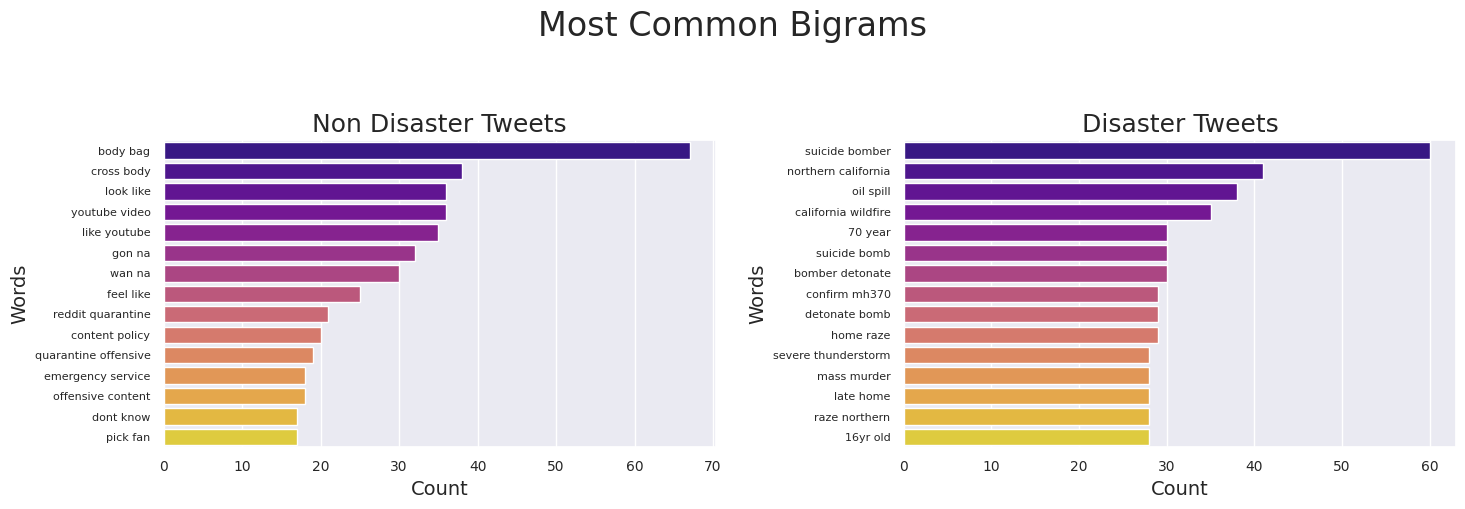

In [ ]:
ngrams(2, 'Most Common Bigrams')

<font face="Monospace" size="5" color="MediumSeaGreen"><b>MOST COMMON BIGRAMS</b></font>

---

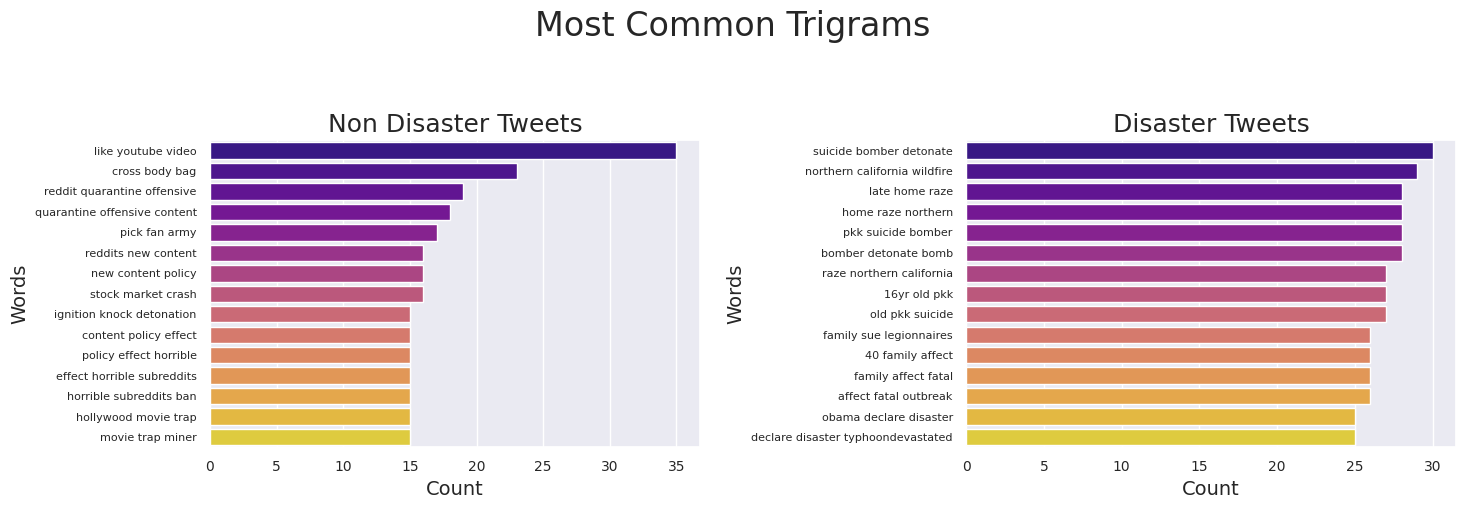

In [ ]:
ngrams(3, 'Most Common Trigrams')

## <font face="Monospace" size="7" color="MediumSeaGreen"><b>SOME EXTRA ANALYSIS</b></font>

---

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>DETERMINING TOPICS</b></font>

---

<font face="Monospace" size="5" color="MediumSeaGreen"><b>NON DISASTER TWEETS</b></font>

---

In [ ]:
def display_topics(text, no_top_words, topic):
    """ A function for determining the topics present in our corpus with nmf """

    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0, init='nndsvd').fit(tfidf)  # Removed 'alpha'
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lis[0], 10, 'Non Disaster Topics\n')

Non Disaster Topics

Topic 1:
get lol blow good bomb first day demolish someone play
Topic 2:
like video youtube look feel back fire fatality sink mudslide
Topic 3:
im traumatise still disaster na gon attack drown dead weapon
Topic 4:
new emergency full read content post quarantine many storm re
Topic 5:
body bag cross shoulder woman full lady read ebay really
Topic 6:
dont one see know come say make want think fire
Topic 7:
scream fuck phone face good song loud hit baby time
Topic 8:
via youtube god change obliteration news story stop service military
Topic 9:
go content quarantine many explode make reddit let top deluge
Topic 10:
love crush collide woman much death military armageddon would check


<font face="Monospace" size="5" color="MediumSeaGreen"><b>DISASTER TWEETS</b></font>

---

In [ ]:
display_topics(lis[1], 10,'Disaster Topics\n')

Disaster Topics

Topic 1:
fire forest building truck evacuate wild burn service california set
Topic 2:
suicide bomb kill bomber saudi mosque detonate pkk old 16yr
Topic 3:
california wildfire home northern late news raze abc collapse burn
Topic 4:
flood storm rain people train issue severe weather rescue violent
Topic 5:
hiroshima atomic bomb year japan still anniversary 70 war bombing
Topic 6:
via attack wave israeli police evacuation heat post wound car
Topic 7:
mh370 family confirm malaysia wreckage pm debris conclusively investigator find
Topic 8:
disaster nuclear obama natural declare saipan typhoondevastated sign collapse northern
Topic 9:
crash kill accident helicopter air train fear say police car
Topic 10:
get watch minute sandstorm swallow airport go im like dont


### <font face="Monospace" size="6" color="MediumSeaGreen"><b>WORD CLOUD</b></font>

---

In [ ]:
mask = np.array(Image.open('/content/drive/MyDrive/DATASET/twittermask.png'))

mask[mask.sum(axis=2) == 0] = 255

In [ ]:
def plot_wordcloud(text, title, title_size):
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)

    # Create a color function
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return tuple(np.random.randint(0, 256, 3))  # Generate random RGB colors

    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
        color_func=color_func  # Use the custom color function
    ).generate_from_frequencies(dict(mostcommon))

    fig = plt.figure(figsize=(6, 6), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'}, fontsize=18)
    plt.tight_layout(pad=0)
    plt.show()


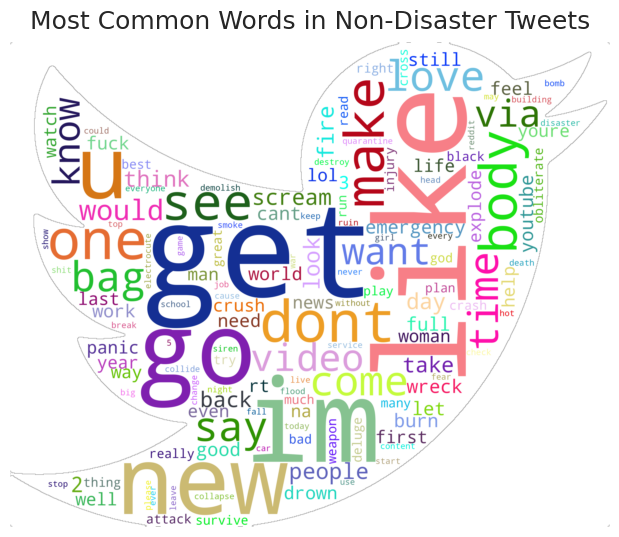

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 0]['lemmatized'],
               'Most Common Words in Non-Disaster Tweets',
               title_size=30)

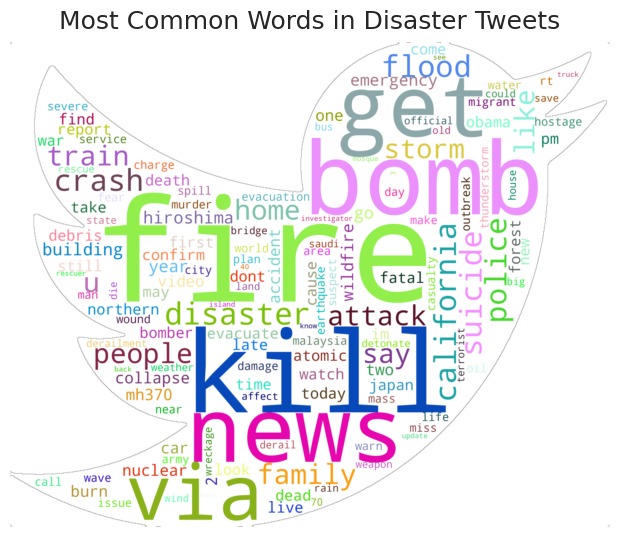

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 1]['lemmatized'],
               'Most Common Words in Disaster Tweets',
               title_size=30)

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>NAMED ENTITY RECOGNITION</b></font>

---

In [ ]:
!python -m spacy download en_core_web_sm

2023-08-27 07:50:54.718593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
def plot_named_entity_barchart(text):

    """A function for extracting named entities and comparing them"""

    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

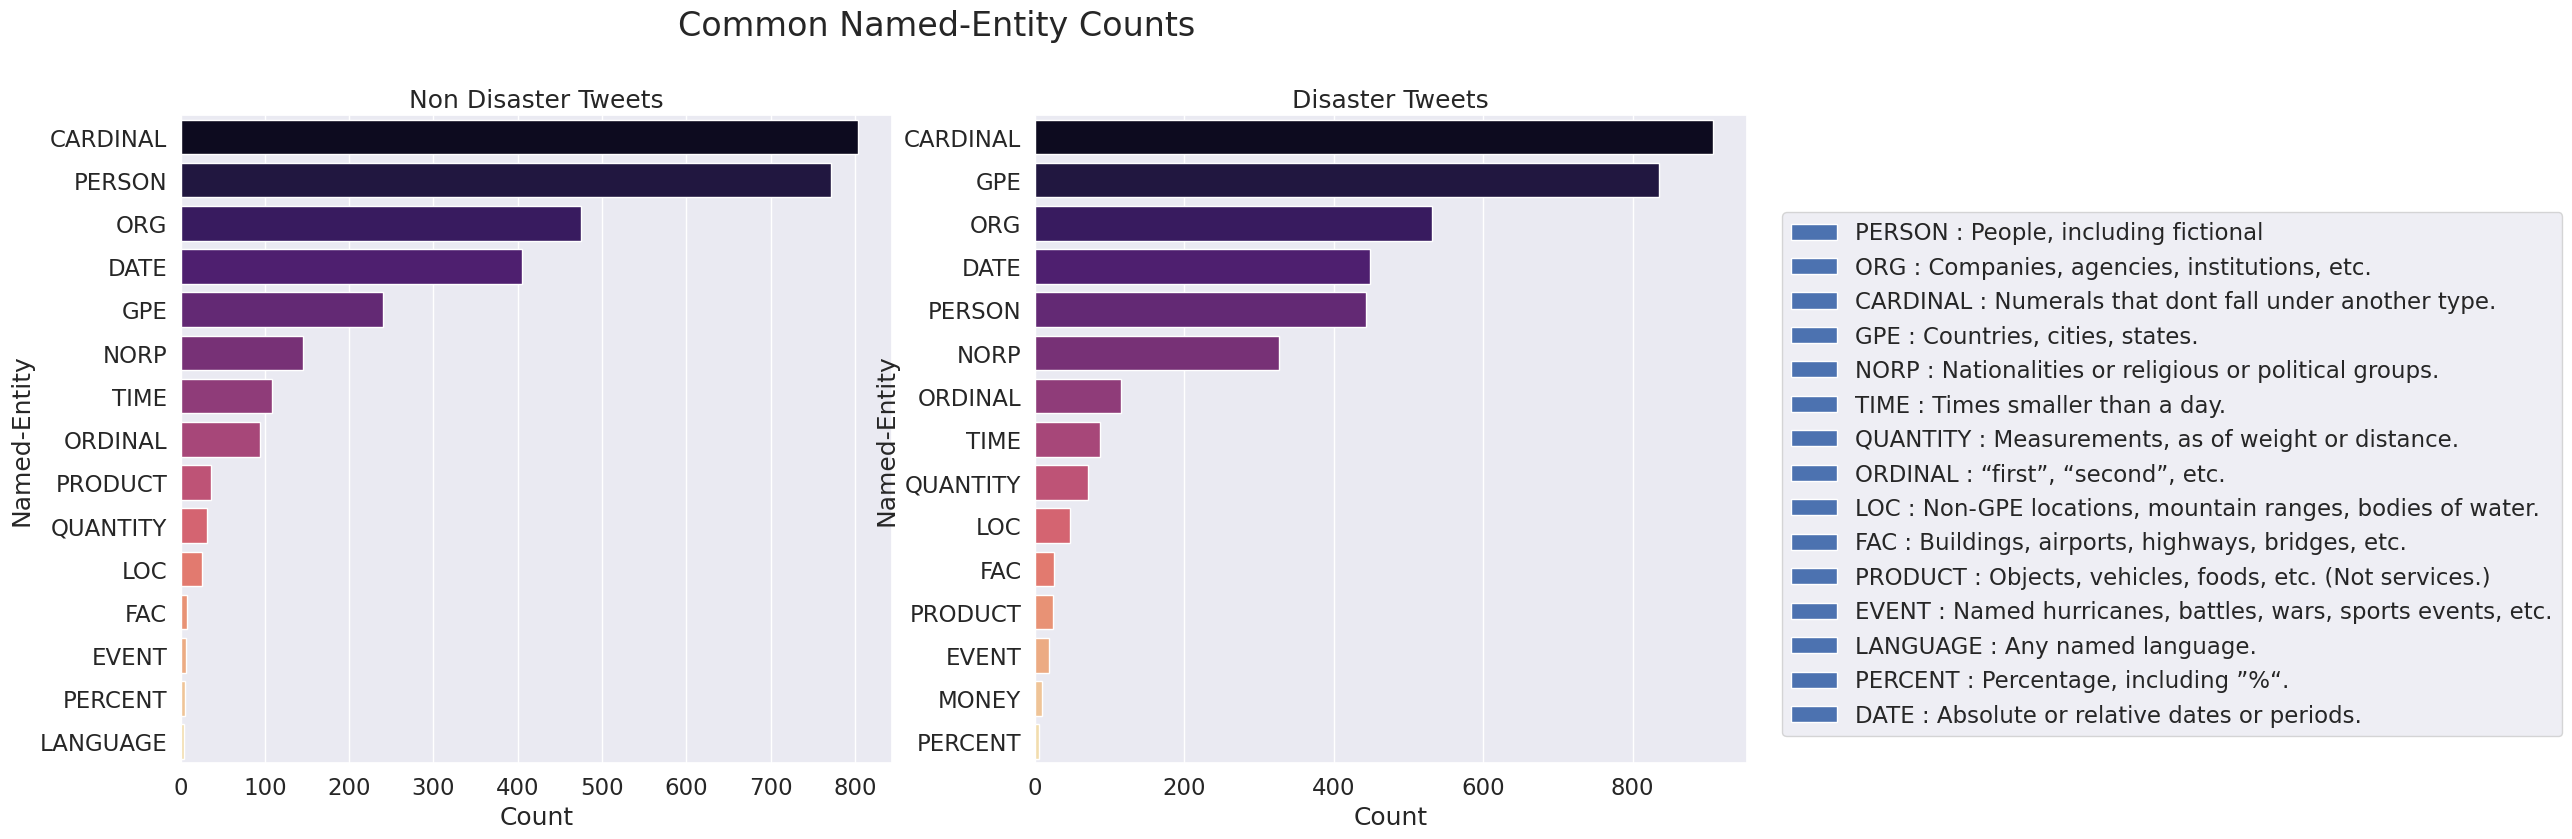

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='magma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

## <font face="Monospace" size="7" color="MediumSeaGreen"><b>BUILDING THE BERT MODEL</b></font>

---

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>GETTING THINGS READY</b></font>

---

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/DATASET/DISTWEET TRAIN.csv')
real_test_data = pd.read_csv('/content/drive/MyDrive/DATASET/DISTWEET TEST.csv')
train_data.fillna(value = 'None', inplace = True)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print (device)

cuda


### <font face="Monospace" size="6" color="MediumSeaGreen"><b>TOKENIZATION AND FORMATTING THE INPUTS</b></font>

---

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
train_values = []
for i in trange(len(train_data)):
    keyword = train_data['keyword'][i]
    location = train_data['location'][i]
    text = train_data['text'][i]

    sentence = keyword+' '+location+' '+text
    train_values.append(sentence)

100%|██████████| 7613/7613 [00:00<00:00, 54463.03it/s]


In [ ]:
train_values = ['[CLS] '+sent+' [SEP]' for sent in train_values]
tokenized_statements = [tokenizer.tokenize(sent) for sent in train_values]
print (tokenized_statements[0])

['[CLS]', 'none', 'none', 'our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all', '[SEP]']


In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_statements]
input_ids = pad_sequences(input_ids, maxlen = 512, dtype = 'long', truncating = 'post', padding = 'post')

In [ ]:
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id>0) for token_id in sent]
    attention_masks.append(att_mask)

In [ ]:
labels = train_data['target'].values

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 42, test_size = 0.15)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 42, test_size = 0.15)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
batch_size = 8

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

### <font face="Monospace" size="6" color="MediumSeaGreen"><b>BERT CLASSIFICATON MODEL</b></font>

---

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False,
                                                      output_hidden_states = False)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
params = list(model.named_parameters())

print ('The BERT model has {:} different named parameters.\n'.format(len(params)))
print ('===== Embedding Layer =======\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

===== Embedding Layer =======

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias           

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [ ]:
epochs = 3

total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return (np.sum(pred_flat == labels_flat)/len(labels_flat))

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step%40 == 0 and not step == 0:
            elapsed = format_time(time.time())
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss/len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    809.    Elapsed: 19596 days, 8:26:37.
  Batch    80  of    809.    Elapsed: 19596 days, 8:27:06.
  Batch   120  of    809.    Elapsed: 19596 days, 8:27:36.
  Batch   160  of    809.    Elapsed: 19596 days, 8:28:06.
  Batch   200  of    809.    Elapsed: 19596 days, 8:28:36.
  Batch   240  of    809.    Elapsed: 19596 days, 8:29:06.
  Batch   280  of    809.    Elapsed: 19596 days, 8:29:36.
  Batch   320  of    809.    Elapsed: 19596 days, 8:30:06.
  Batch   360  of    809.    Elapsed: 19596 days, 8:30:36.
  Batch   400  of    809.    Elapsed: 19596 days, 8:31:06.
  Batch   440  of    809.    Elapsed: 19596 days, 8:31:36.
  Batch   480  of    809.    Elapsed: 19596 days, 8:32:06.
  Batch   520  of    809.    Elapsed: 19596 days, 8:32:36.
  Batch   560  of    809.    Elapsed: 19596 days, 8:33:06.
  Batch   600  of    809.    Elapsed: 19596 days, 8:33:36.
  Batch   640  of    809.    Elapsed: 19596 days, 8:34:06.
  Batch   680

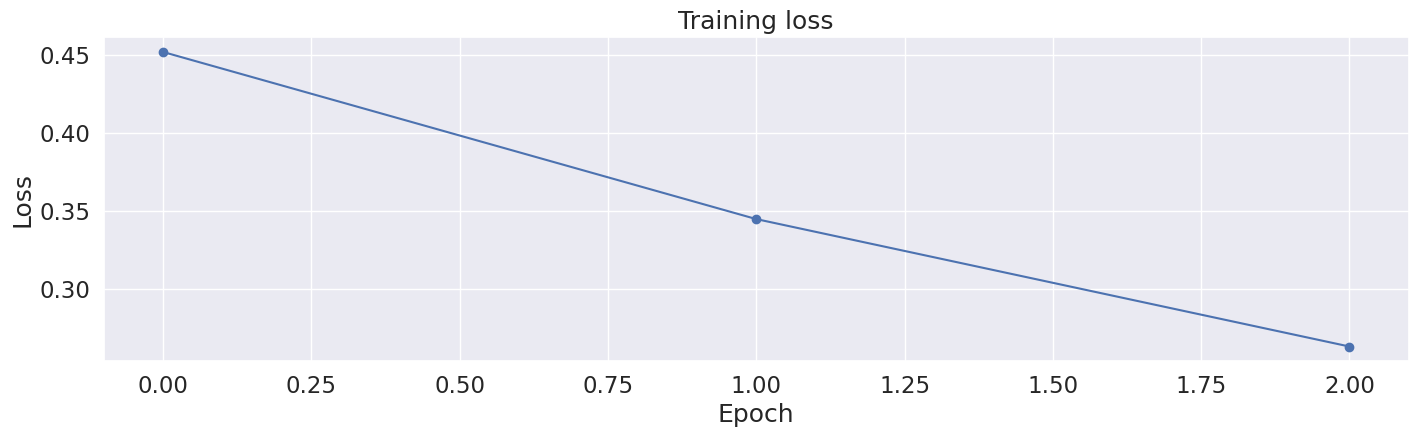

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,4)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


## <font face="Monospace" size="7" color="MediumSeaGreen"><b>PREDICTION </b></font>

---

In [ ]:
real_test_data.isnull().sum()
real_test_data.fillna(value = 'None', inplace = True)

In [ ]:
test_values = []
for i in trange(len(real_test_data)):
    keyword = real_test_data['keyword'][i]
    location = real_test_data['location'][i]
    text = real_test_data['text'][i]

    sentence = keyword+' '+location+' '+text
    test_values.append(sentence)

100%|██████████| 3263/3263 [00:00<00:00, 24557.67it/s]


In [ ]:
test_values = ['[CLS] '+sent+' [SEP]' for sent in test_values]
test_tokenized_statements = [tokenizer.tokenize(sent) for sent in test_values]
print (test_tokenized_statements[0])

['[CLS]', 'none', 'none', 'just', 'happened', 'a', 'terrible', 'car', 'crash', '[SEP]']


In [ ]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_statements]
test_input_ids = pad_sequences(test_input_ids, maxlen = 512, dtype = 'long', truncating = 'post', padding = 'post')

In [ ]:
test_attention_masks = []

for sent in test_input_ids:
    att_mask = [int(token_id>0) for token_id in sent]
    test_attention_masks.append(att_mask)

In [ ]:
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)

In [ ]:
batch_size = 8

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [ ]:
# print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    predictions.append(logits)
print('DONE.')

DONE.


In [ ]:
preds = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        preds.append(np.argmax(predictions[i][j]))
test_predictions =  pd.DataFrame({
    'id': real_test_data['id'],
    'target': preds,
    'text': real_test_data['text']  # Adding the text column to the submission DataFrame
})
test_predictions['id'] = real_test_data['id']
test_predictions['target'] = preds
test_predictions.head(10)

,id,target,text
0,0,1,Just happened a terrible car crash
1,2,1,"Heard about #earthquake is different cities, s..."
2,3,1,"there is a forest fire at spot pond, geese are..."
3,9,1,Apocalypse lighting. #Spokane #wildfires
4,11,1,Typhoon Soudelor kills 28 in China and Taiwan
5,12,1,We're shaking...It's an earthquake
6,21,0,They'd probably still show more life than Arse...
7,22,0,Hey! How are you?
8,27,0,What a nice hat?
9,29,0,Fuck off!
